In [1]:
# Partial Fitting. Alternative xgboost would be a best choose
#    'Perceptron': Perceptron(),
    #'NB Multinomial': MultinomialNB(alpha=0.01),
    #'Passive-Aggressive': PassiveAggressiveClassifier() -- slow to train

In [2]:
from helper import (load_data, token, show_diagram,time_me,
                      show_most_informative_features)

In [3]:
## Same process timing with %time does not work. We also needed something human ;)
from datetime import datetime
import humanfriendly


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

In [5]:
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

#### Why HashingVectorizer? TfidfVectorizer, CountVectorizer + TfidfTransformer

In [6]:

from sklearn.linear_model import SGDClassifier

In [7]:
stops = joblib.load('../stops.pkl')

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Down sampling positive ratings to match negatives
Data loading completed
{1: 127232, 0: 127232} 

Execution Time: 5 seconds


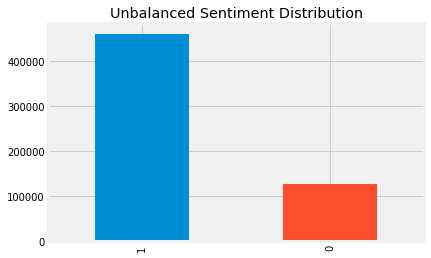

In [8]:
df = load_data('../sentiment_data', balanced=True) # Using unbalance Data

In [9]:
 X_train, X_test, y_train, y_test = train_test_split(df['features'], df['y'],
                                                    test_size=.1, random_state=7,stratify=df['y'])

In [10]:
hash_para = dict(decode_error='ignore', n_features=2**18, tokenizer=token,
                stop_words=stops, ngram_range=(1,3), alternate_sign=False)
clf_prep = HashingVectorizer(**hash_para)

In [11]:
clf_prep = HashingVectorizer(**hash_para)
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)

In [12]:
@time_me
def sgd_model(X,y=None,method=None):
    if method == 'train':
        print('Training Model...')
        u = datetime.now()
        clf.partial_fit(clf_prep.transform(X), y,classes=np.unique(y))
        v = datetime.now()
        delta = v-u
        print('Training took: {}'.format(
            humanfriendly.format_timespan(delta.seconds)))

        return clf
    if method == 'score':
        print('Scoring Model...')
        u = datetime.now()
        score = clf.score(clf_prep.transform(X),y)
        v = datetime.now()
        delta = v-u
        print('Scoring took: {}'.format(
            humanfriendly.format_timespan(delta.seconds)))
        
        return score
    
    if method == 'predict':
        return clf.predict(clf_prep.transform(X))
    else:
        return clf.predict_proba(clf_prep.transform(X))
        
   

In [13]:
clf = sgd_model(X_train,y_train,'train')

Training Model...
Training took: 55 seconds
Execution Time: 55 seconds


In [14]:
score = sgd_model(X_test,y_test,'score')

Scoring Model...
Scoring took: 6 seconds
Execution Time: 6 seconds


In [15]:
score

0.9180257004754981

In [16]:
X_train_ , X_test_ = clf_prep.transform(X_train), clf_prep.transform(X_test)

Classification Report
	 _____________________________________________
             precision    recall  f1-score   support

   Negative       0.90      0.94      0.92     12723
   Positive       0.94      0.90      0.92     12724

avg / total       0.92      0.92      0.92     25447

	 _____________________________________________ 




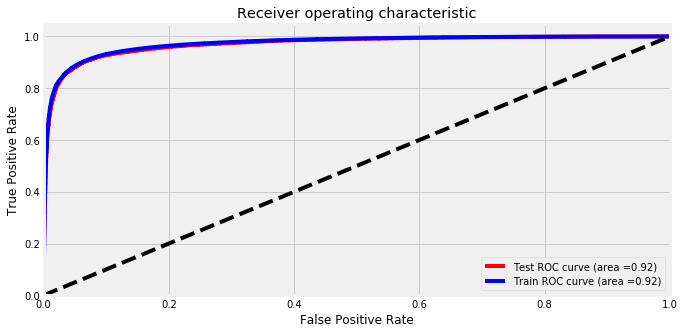

Execution Time: 1 second


In [17]:
show_diagram(clf,X_train_, y_train, X_test_, y_test,compare_test=True)

In [19]:
# Use update mode with remaining data
# Since we have partial_fit, we can just fit in the remaining

clf = sgd_model(X_test,y_test,'train')


Training Model...
Training took: 6 seconds
Execution Time: 6 seconds


In [22]:
joblib.dump(clf_prep, '../HashVectorizer.pkl')
joblib.dump(clf, '../SGDclassifier.pkl')

['../SGDclassifier.pkl']